### Задача 1.

У нас есть данные АА-теста с '2022-05-17' по '2022-05-23'. Нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации вам нужно сформировать подвыборки с повторением в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

In [83]:
import pandahouse
import swifter
import hashlib
import seaborn as sns
import numpy as np
from scipy import stats
import pandas as pd

In [1]:
#функция разделения данных на экспериментальные группы

def ab_split(id, salt = 'exp_mess_1', n_groups = 5):
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

In [2]:
#вытаскиваем пользователей из clickhouse

connection = {
    'host': '***********',
    'password': '*******',
    'user':'*******',
    'database':'*********'
}

q = """
select distinct user_id
from {db}.feed_actions
where toDate(time) >= '2022-05-17' and toDate(time) <= '2022-05-23'
"""

users_df = pandahouse.read_clickhouse(q, connection = connection)

In [12]:
users_df['hash_group'] = users_df.user_id.swifter.apply(ab_split)

Pandas Apply:   0%|          | 0/42585 [00:00<?, ?it/s]

In [13]:
users_df.groupby('hash_group').user_id.nunique().reset_index()

,hash_group,user_id
0,0,8725
1,1,8354
2,2,8516
3,3,8433
4,4,8557


In [16]:
#вытаскиваем данные по пользователям из clickhouse

q = """
select exp_group, user_id, 
       sum(action = 'like') as likes,
       sum(action = 'view') as views,
       likes/views as ctr
from {db}.feed_actions
where toDate(time) >= '2022-05-17' and toDate(time) <= '2022-05-23'
      and exp_group in (2, 3)
group by exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection = connection)

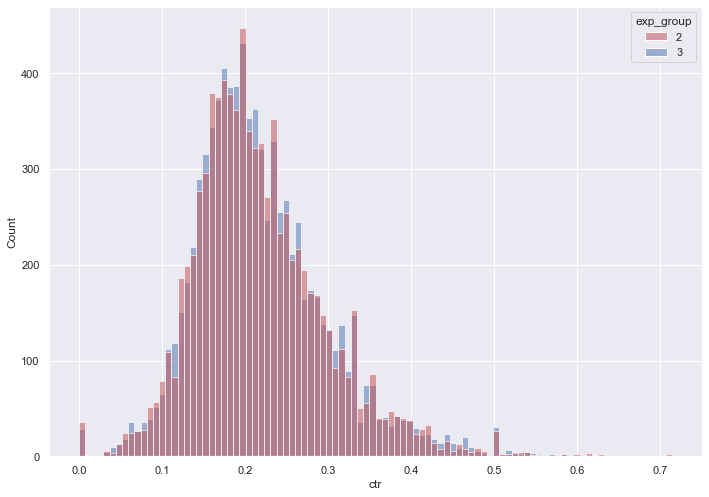

In [19]:
#визуализация распределения метрики ctr для второй и третьей группы пользователей

sns.set(rc = {'figure.figsize':(11.7, 8.27)})

groups = sns.histplot(data = df, 
                      x = 'ctr',
                      hue = 'exp_group',
                      palette = ['r', 'b'],
                      alpha = 0.5,
                      kde = False)

In [112]:
#реализация AA-теста, формирование подвыборок и сравнение их t-тестом

%%time
df_group_2 = df[df['exp_group']==2].reset_index(drop = True)
df_group_3 = df[df['exp_group']==3].reset_index(drop = True)

p_value = []

for i in range(0, 10000):
    
    statistic, pvalue = stats.ttest_ind(df_group_2.ctr.sample(500, replace = True),
                                        df_group_3.ctr.sample(500, replace = True),
                                        equal_var = False)
    
    p_value.append(pvalue)

CPU times: user 8.64 s, sys: 117 ms, total: 8.76 s
Wall time: 9.32 s


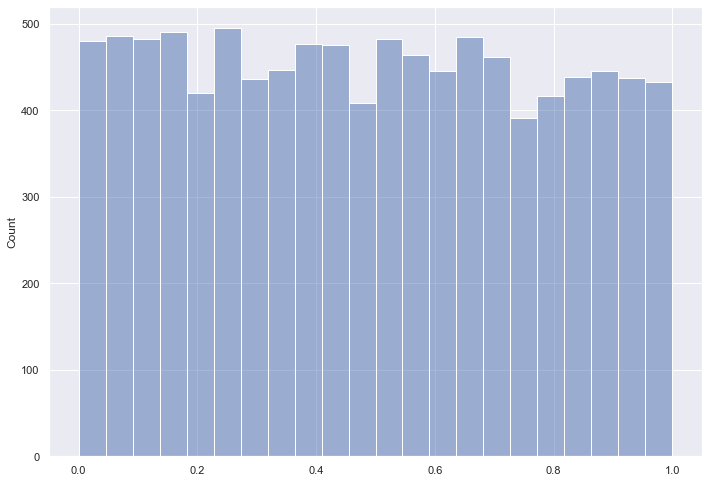

In [113]:
pvalue = sns.histplot(data = p_value, 
                      alpha = 0.5,
                      kde = False)

In [114]:
df_p_value = pd.DataFrame(p_value)
df_p_value[df_p_value[0] <= 0.05].shape[0]/df_p_value.shape[0]

0.0527

Приблизительно в 5% случаев у нас получаются статистические значимые различия между 2 и 3 группой. Из чего можно сделать вывод, что система сплитования работает корректно.